<a href="https://colab.research.google.com/github/JasonL888/Book_PyTorchPocketReference/blob/main/chap04_imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import datasets, models
from torchvision import transforms

import numpy as np

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

import matplotlib.pyplot as plt

# Data Processing

In [2]:
zipurl = 'https://pytorch.tips/bee-zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('./data')

Note:
- Data augmentations to make models more robust to variations in size and position
    - RandomResizedCrop to 224x224 (standard input for many pretrained CNNs)
    - RandomHorizontalFlip (eg. if cat facing left or right)
- [ToTensor() docs](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) also does
    - scale pixel values from range [0,255] to [0.0,1.0]
    - rearranges dimensions from (height, width, channels) to (channels,height,width) - format expected by PyTorch
- Normalize
    - applies $\frac{(channel-mean)}{std}$ for each channel


Note:
- data augment only for training, **NOT** for validation

In [3]:
train_transforms = transforms.Compose([     # Chain multiple transformations
    transforms.RandomResizedCrop(224),      # Randomly crops image and resize to 224x224
    transforms.RandomHorizontalFlip(),      # Randomly flip image horizontally (left-right) with default probability 0.5
    transforms.ToTensor(),                  # Converts PIL image or numpy array to PyTorch tensor
    transforms.Normalize(
        [0.485, 0.456, 0.406],              # ImageNet means for 3 channels (Red, Green, Blue)
        [0.229, 0.224, 0.225]               # ImageNet std dev for each channel
    )
])

In [4]:
val_transforms = transforms.Compose([       # Chain multiple transformations
    transforms.Resize(256),                 # Resize to 256x256
    transforms.CenterCrop(224),             # Crop in center 224x224
    transforms.ToTensor(),                  # Converts PIL image or numpy array to PyTorch tensor
    transforms.Normalize(
        [0.485, 0.456, 0.406],              # ImageNet means for 3 channels (Red, Green, Blue)
        [0.229, 0.224, 0.225]               # ImageNet std dev for each channel
    )
])

In [5]:
train_dataset = datasets.ImageFolder(
    root='data/hymenoptera_data/train',
    transform=train_transforms
)

In [6]:
val_dataset = datasets.ImageFolder(
    root='data/hymenoptera_data/val',
    transform=val_transforms
)

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,   # batch of 4 at time
    shuffle=True,   # shuffle
    num_workers=4   # configure for 4 CPU processors in parallel
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,   # batch of 4 at time
    shuffle=True,   # shuffle
    num_workers=4   # configure for 4 CPU processors in parallel
)

# Model Design

ResetNet18 model
- pretrained with ImageNet data
- designed to detect 1000 classes
    - in our case we only need 2 classes (bees and ants)
    - modify final layer to detect 2 classes instead of 1000

In [9]:
# Downloads model to ~/.cache/torch/hub/checkpoints/resnet18-xxx.pth
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [10]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [11]:
# read the number of featues before final layer
num_ftrs = model.fc.in_features
# change final layer by setting directly to fully connected layer with 2 outputs
model.fc = nn.Linear(num_ftrs, 2)

In [12]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

going to
- use the pretrained model as starting point
- fine-tune its parameters with new data
    - since we replaced the final linear layer, it's parameters are now randomly initialized

# Training and Validation

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
model = model.to(device)

In [15]:
criterion = nn.CrossEntropyLoss() # Define or loss function

In [16]:
optimizer = optim.SGD(  # Define our optimizer algorithm
    model.parameters(),
    lr=0.001,
    momentum=0.9
)

using a PyTorch scheduler to adjust the learning rate of our SGD optimizer after several epochs
- will help our NN adjust weights more precisely as training goes on

In [17]:
exp_lr_scheduler = StepLR( # Use a Learning Rate scheduler
    optimizer,
    step_size=7,
    gamma=0.1
)

In [19]:
num_epochs=25

for epoch in range(num_epochs):
    model.train()                       # Training loop
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)/inputs.size(0)

    exp_lr_scheduler.step()         # Schedule the learning rate for next epoch of training

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval()                    # Validation loop
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)/inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)

    print(f'Train: Loss:{train_epoch_loss:.4f} Acc:{train_epoch_acc:4f} Val: Loss:{epoch_loss:.4f} Acc:{epoch_acc:.4f}')

Train: Loss:0.1600 Acc:0.663934 Val: Loss:0.0517 Acc:0.9167
Train: Loss:0.1286 Acc:0.807377 Val: Loss:0.1026 Acc:0.8333
Train: Loss:0.1903 Acc:0.737705 Val: Loss:0.0560 Acc:0.8974
Train: Loss:0.1314 Acc:0.790984 Val: Loss:0.1690 Acc:0.7628
Train: Loss:0.0922 Acc:0.836066 Val: Loss:0.0706 Acc:0.9231
Train: Loss:0.1097 Acc:0.811475 Val: Loss:0.0570 Acc:0.9038
Train: Loss:0.0808 Acc:0.860656 Val: Loss:0.0522 Acc:0.9359
Train: Loss:0.0761 Acc:0.885246 Val: Loss:0.0501 Acc:0.9167
Train: Loss:0.0734 Acc:0.868852 Val: Loss:0.0448 Acc:0.9487
Train: Loss:0.0714 Acc:0.893443 Val: Loss:0.0440 Acc:0.9295
Train: Loss:0.0889 Acc:0.848361 Val: Loss:0.0470 Acc:0.9487
Train: Loss:0.0786 Acc:0.852459 Val: Loss:0.0541 Acc:0.9103
Train: Loss:0.0541 Acc:0.905738 Val: Loss:0.0479 Acc:0.9359
Train: Loss:0.0713 Acc:0.889344 Val: Loss:0.0478 Acc:0.9423
Train: Loss:0.0697 Acc:0.881148 Val: Loss:0.0493 Acc:0.9423
Train: Loss:0.0786 Acc:0.831967 Val: Loss:0.0461 Acc:0.9487
Train: Loss:0.0713 Acc:0.868852 Val: Los

# Testing and Deployment

In [20]:
def imshow(inp, title=None):                    # define a new function to plot images from our tensor images
    inp = inp.numpy().transpose((1,2,0))        # switch from C x H x W to H x W x C
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                      # undo the normalizations during transforms to properly view images
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

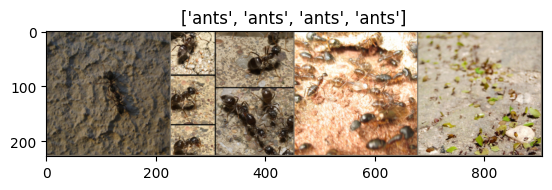

In [21]:
inputs, classes = next(iter(val_loader))            # Grab a batch of images from our validation dataset
out = torchvision.utils.make_grid(inputs)
class_names = val_dataset.classes

outputs = model(inputs.to(device))                  # Perform classification using our fine-tuned ResNet18
_, preds = torch.max(outputs, 1)                    # Take the "winning" class

imshow(out, title=[class_names[x] for x in preds])  # Display the input images and their predicted classes

In [22]:
torch.save(model.state_dict(), "./resnet18.pt")